# 0. Setup

In [1]:
import os

wd_path = "/home/bastebun/work/project_paaral"
if os.getcwd() != wd_path:
    os.chdir(wd_path)
else:
    pass

In [2]:
import re
import sys
import copy
import math
import time
import pickle
import numpy as np
import pandas as pd
import multiprocessing
from collections import Counter
import matplotlib.pyplot as plt

from config.config import Config
cf = Config()

import importlib
def reload_module(module):
    importlib.reload(module)

# 1. Load data

In [3]:
%%time
# Load parquet of ESC beneficiaries
path_parquet = "data/processed/esc_beneficiaries.parquet"
df_esc = pd.read_parquet(path_parquet)

print(df_esc.shape)
display(df_esc.head(3))

(2681668, 13)


,deped_school_id,lrn,esc_school_id,school_name,grade,billing_statement_number,esc_subsidy_amount,sheet_name,school_year,grade_level,lrn_validated,lrn_school_id,region
0,475511,133526130177,1603520,"Adiong Memorial College Foundation, Inc.",9,ESC-227153,9000.0,BARMM,SY 2022-2023,Grade 9,133526130177,133526,BARMM
1,475511,133536150012,1603520,"Adiong Memorial College Foundation, Inc.",7,ESC-227153,9000.0,BARMM,SY 2022-2023,Grade 7,133536150012,133536,BARMM
2,475511,133536150011,1603520,"Adiong Memorial College Foundation, Inc.",7,ESC-227153,9000.0,BARMM,SY 2022-2023,Grade 7,133536150011,133536,BARMM


CPU times: user 24.2 s, sys: 2.13 s, total: 26.4 s
Wall time: 12.7 s


In [4]:
display(df_esc.dtypes)

deped_school_id             string[python]
lrn                         string[python]
esc_school_id               string[python]
school_name                 string[python]
grade                       string[python]
billing_statement_number    string[python]
esc_subsidy_amount                 float64
sheet_name                        category
school_year                       category
grade_level                       category
lrn_validated               string[python]
lrn_school_id                       object
region                            category
dtype: object

# 2. Exploratory Data Analysis

## 2.1. Descriptive

### By SY & Grade

In [5]:
# Total ESC beneficiary by SY and grade level
df_tmp = df_esc.copy()

# Create a list with the desired order
grade_order = ['Grade 7', 'Grade 8', 'Grade 9', 'Grade 10']

# Reorder the categories in the column
#    - ordered=True is crucial to tell pandas to use this specific order for sorting
df_tmp['grade_level'] = df_tmp['grade_level'].cat.reorder_categories(grade_order, ordered=True)

df_pvta = df_esc.pivot_table(
    index='school_year',
    columns='grade_level',
    values='lrn',
    aggfunc='nunique',
    observed=False,
)
df_pvta = df_pvta[df_tmp['grade_level'].cat.categories.to_list()]

display(df_pvta.style.format(thousands=','))

grade_level,Grade 7,Grade 8,Grade 9,Grade 10
school_year,,,,
SY 2022-2023,"236,464","215,173","221,312","247,933"
SY 2023-2024,"226,075","231,807","217,382","221,751"
SY 2024-2025,"250,634","203,480","209,620","200,019"


### By Region & SY

In [6]:
# Total ESC beneficiary by Region and SY
df_pvtb = df_tmp.pivot_table(
    index='region',
    columns='school_year',
    values='lrn',
    aggfunc='nunique',
    observed=False,
)
# display(df_pvtb.style.format(thousands=','))

In [7]:
pvtb_pct = df_pvtb.copy()
pvtb_pct = pvtb_pct.astype('float')

for idx, row in pvtb_pct.iterrows():
    row_sum = row.sum()
    # display(row_sum)
    row_pct = (row / row_sum) * 100
    # display(row_pct)
    pvtb_pct.loc[idx, :] = row_pct
    # break

display(pvtb_pct)

school_year,SY 2022-2023,SY 2023-2024,SY 2024-2025
region,,,
BARMM,33.262769,33.790890,32.946341
CAR,34.810416,33.446849,31.742736
CARAGA,34.490341,33.599230,31.910429
MIMAROPA,34.686585,33.419742,31.893673
NCR,33.501771,33.365538,33.132691
Region I,35.029895,33.094222,31.875883
Region II,34.699325,33.311672,31.989003
Region III,34.025327,33.273640,32.701032
Region IV-A,33.520894,33.231845,33.247261


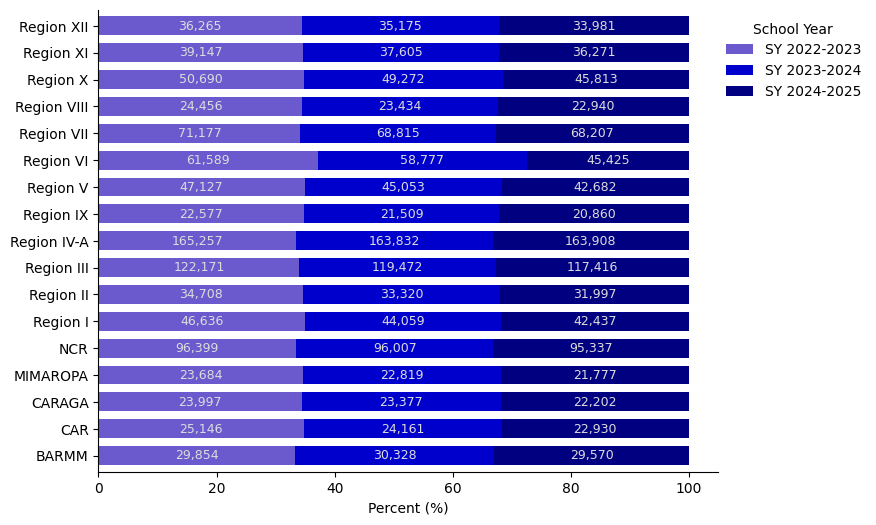

In [8]:
fig, ax = plt.subplots(figsize=(8,6))

pvtb_pct.plot(
    ax=ax,
    kind='barh',
    stacked=True,
    color=['slateblue','mediumblue','navy'],
    width=.7,
)
ax.spines[['top','right']].set_visible(False)
ax.set_ylabel('')
ax.set_xlabel('Percent (%)')

# Annotate each bar segment with its value
df_cols = df_pvtb.columns
for i, container in enumerate(ax.containers):
    # labels = [f'{w:.2f}' for w in container.datavalues]
    dvs = [f'{v:,}' for v in df_pvtb.loc[:, df_cols[i]].values]
    ax.bar_label(
        container,
        labels=dvs,
        label_type='center',
        fmt='{:,}',
        size=9,
        color='gainsboro'
    )

# Place the legend at the top right, outside the plot
ax.legend(
    title='School Year',
    loc='upper right',
    bbox_to_anchor=(1.25, 1),
    frameon=False,
)

plt.show()

### Build LRN table

In [9]:
# Count of unique LRNs
uniq_lrns = df_esc['lrn'].unique()
print(f"{len(uniq_lrns):,}")

1,636,178


In [10]:
# Count of unique validated LRNs
uniq_val_lrns = df_esc['lrn_validated'].unique()
print(f"{len(uniq_val_lrns):,}")

1,436,123


In [11]:
display(df_esc.head(1))

,deped_school_id,lrn,esc_school_id,school_name,grade,billing_statement_number,esc_subsidy_amount,sheet_name,school_year,grade_level,lrn_validated,lrn_school_id,region
0,475511,133526130177,1603520,"Adiong Memorial College Foundation, Inc.",9,ESC-227153,9000.0,BARMM,SY 2022-2023,Grade 9,133526130177,133526,BARMM


In [12]:
tmp_bf = df_esc.copy()

# Only include rows with valid LRNs
mask = tmp_bf['lrn_validated'].str.contains(r'invalid|no')
tmp_bf = tmp_bf.loc[~mask]

agg_bf = tmp_bf.groupby(['lrn_validated','school_year'], observed=False)['lrn_validated'].nunique()

In [13]:
# display(agg_bf)

In [14]:
agg_tmp = agg_bf.copy().to_frame()

agg_tmp.columns = ['in_sy']
agg_tmp = agg_tmp.reset_index()

display(agg_tmp.head(3))

,lrn_validated,school_year,in_sy
0,100001140002,SY 2022-2023,1
1,100001140002,SY 2023-2024,1
2,100001140002,SY 2024-2025,1


In [15]:
%%time
pvt_bf = agg_tmp.pivot_table(
    index='lrn_validated',
    columns='school_year',
    values='in_sy',
    aggfunc='sum',
    observed=False
)
display(pvt_bf)

school_year,SY 2022-2023,SY 2023-2024,SY 2024-2025
lrn_validated,,,
100001140002,1,1,1
100002110044,1,0,0
100002120006,1,0,0
100002120014,1,0,0
100002120025,1,0,0
...,...,...,...
977201150192,1,1,0
977201150219,1,0,0
977201150221,1,0,0


CPU times: user 44.6 s, sys: 847 ms, total: 45.4 s
Wall time: 45.2 s


In [16]:
sy_cols = ['beneficiary_'+'_'.join(col.lower().split(' ')) for col in pvt_bf.columns]
print(sy_cols)

tmp_pvt_bf = pvt_bf.copy()
tmp_pvt_bf.columns = sy_cols


tmp_pvt_bf = tmp_pvt_bf.reset_index()
print(tmp_pvt_bf.shape)
display(tmp_pvt_bf.head(3))

['beneficiary_sy_2022-2023', 'beneficiary_sy_2023-2024', 'beneficiary_sy_2024-2025']
(1436120, 4)


,lrn_validated,beneficiary_sy_2022-2023,beneficiary_sy_2023-2024,beneficiary_sy_2024-2025
0,100001140002,1,1,1
1,100002110044,1,0,0
2,100002120006,1,0,0


In [17]:
tmp_bfb = df_esc.copy()

# Only include rows with valid LRNs
mask = tmp_bfb['lrn_validated'].str.contains(r'invalid|no')
tmp_bfb = tmp_bfb.loc[~mask]

agg_bfb = tmp_bfb.groupby(['lrn_validated','grade_level'], observed=False)['lrn_validated'].nunique()

In [18]:
# display(agg_bfb)

In [19]:
agg_tmpb = agg_bfb.copy().to_frame()

agg_tmpb.columns = ['in_grade_level']
agg_tmpb = agg_tmpb.reset_index()

display(agg_tmpb.head(3))

,lrn_validated,grade_level,in_grade_level
0,100001140002,Grade 10,1
1,100001140002,Grade 7,0
2,100001140002,Grade 8,1


In [20]:
%%time
pvt_bfb = agg_tmpb.pivot_table(
    index='lrn_validated',
    columns='grade_level',
    values='in_grade_level',
    aggfunc='sum',
    observed=False
)
display(pvt_bfb.head())

grade_level,Grade 10,Grade 7,Grade 8,Grade 9
lrn_validated,,,,
100001140002,1,0,1,1
100002110044,1,0,0,0
100002120006,1,0,0,0
100002120014,0,0,0,1
100002120025,1,0,0,0


CPU times: user 47.9 s, sys: 1.64 s, total: 49.5 s
Wall time: 49.4 s


In [21]:
pvt_gl = pvt_bfb[grade_order].copy()
pvt_gl.columns = ['in_'+'_'.join(col.lower().split(' ')) for col in pvt_gl.columns]
pvt_gl = pvt_gl.reset_index()

print(pvt_gl.shape)
display(pvt_gl.head())

(1436120, 5)


,lrn_validated,in_grade_7,in_grade_8,in_grade_9,in_grade_10
0,100001140002,0,1,1,1
1,100002110044,0,0,0,1
2,100002120006,0,0,0,1
3,100002120014,0,0,1,0
4,100002120025,0,0,0,1


In [22]:
mrg_lrn = tmp_pvt_bf.merge(
    pvt_gl,
    left_on='lrn_validated',
    right_on='lrn_validated',
    how='left'
)
print(mrg_lrn.shape)
display(mrg_lrn.head(3))

(1436120, 8)


,lrn_validated,beneficiary_sy_2022-2023,beneficiary_sy_2023-2024,beneficiary_sy_2024-2025,in_grade_7,in_grade_8,in_grade_9,in_grade_10
0,100001140002,1,1,1,0,1,1,1
1,100002110044,1,0,0,0,0,0,1
2,100002120006,1,0,0,0,0,0,1


In [23]:
# mrg_lrn.sample(10)

In [24]:
# tmp_bfb[tmp_bfb['lrn_validated'].duplicated()]
agg_schs = tmp_bfb.groupby(['lrn_validated'])['deped_school_id'].unique()

In [25]:
# display(agg_schs.head(3))

In [26]:
df_schs = agg_schs.to_frame()
df_schs.columns = ['unique_esc_jhs']
df_schs = df_schs.reset_index()

print(df_schs.shape)
display(df_schs.head(2))

(1436120, 2)


,lrn_validated,unique_esc_jhs
0,100001140002,[400462]
1,100002110044,[406432]


In [27]:
dupe_lrns = df_schs[df_schs['lrn_validated'].duplicated()]['lrn_validated'].unique()
print(len(dupe_lrns))

0


In [28]:
schs = df_schs.copy()
schs['esc_jhs_list'] = schs['unique_esc_jhs'].apply(lambda x: ','.join(x))
print(schs.shape)

(1436120, 3)


In [29]:
schs.head(3)

,lrn_validated,unique_esc_jhs,esc_jhs_list
0,100001140002,[400462],400462
1,100002110044,[406432],406432
2,100002120006,[400001],400001


In [31]:
%%time
mrg_lrns = mrg_lrn.merge(
    schs[['lrn_validated','esc_jhs_list']],
    left_on='lrn_validated',
    right_on='lrn_validated',
    how='left'
)
print(mrg_lrns.shape)

(1436120, 9)
CPU times: user 3.56 s, sys: 209 ms, total: 3.77 s
Wall time: 3.77 s


In [34]:
display(mrg_lrns.head(3))

,lrn_validated,beneficiary_sy_2022-2023,beneficiary_sy_2023-2024,beneficiary_sy_2024-2025,in_grade_7,in_grade_8,in_grade_9,in_grade_10,esc_jhs_list
0,100001140002,1,1,1,0,1,1,1,400462
1,100002110044,1,0,0,0,0,0,1,406432
2,100002120006,1,0,0,0,0,0,1,400001


In [35]:
display(mrg_lrns[mrg_lrns['esc_jhs_list'].str.contains(r',')])

,lrn_validated,beneficiary_sy_2022-2023,beneficiary_sy_2023-2024,beneficiary_sy_2024-2025,in_grade_7,in_grade_8,in_grade_9,in_grade_10,esc_jhs_list
194,100025140006,1,1,1,0,1,1,1,"400003,400002"
430,100026150068,1,1,1,1,1,1,0,"400003,400004"
654,100032150013,1,1,1,1,1,1,0,"400003,400004"
704,100033140016,1,1,1,0,1,1,1,"400004,400003"
707,100033150014,1,1,1,1,1,1,0,"400004,400003"
...,...,...,...,...,...,...,...,...,...
1436041,700033190363,1,1,0,0,0,1,1,"403581,466150"
1436054,700033190426,1,1,1,1,1,1,0,"404140,404129"
1436064,700033190527,1,1,1,1,1,1,0,"406384,424285"
1436065,700033190529,1,1,1,1,1,1,0,"401662,401686"


In [32]:
savepath = 'output/table_beneficiaries_lrns.pkl'
with open(savepath, 'wb') as file:
    pickle.dump(mrg_lrns, file)